## __The Segmentation of Credit Card Customers using K-Means Analysis__

The data engineering team has provided a dataset of customer information for a credit card company. The aim is to use K-Means Analysis to cluster customers in order to apply different business strategies for each "type" of customer.

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customers = pd.read_csv('data/customer_segmentation.csv')

print("The first 2 rows of the dataset:\n",customers.head(2),"\n")

print("The dataset has a shape (rows, columns) of:\n",customers.shape,"\n")

print("The dataset has the following DTypes:\n",customers.dtypes,"\n")

print("The number of NaN values across the columns are:\n",customers.isnull().sum())

The first 2 rows of the dataset:
    customer_id  age gender  dependent_count education_level marital_status  \
0    768805383   45      M                3     High School        Married   
1    818770008   49      F                5        Graduate         Single   

   estimated_income  months_on_book  total_relationship_count  \
0             69000              39                         5   
1             24000              44                         6   

   months_inactive_12_mon  credit_limit  total_trans_amount  \
0                       1       12691.0                1144   
1                       1        8256.0                1291   

   total_trans_count  avg_utilization_ratio  
0                 42                  0.061  
1                 33                  0.105   

The dataset has a shape (rows, columns) of:
 (10127, 14) 

The dataset has the following DTypes:
 customer_id                   int64
age                           int64
gender                       object

The dataset contains 14 columns and 10,127 rows. It is complete with no NaN values in any column. The customer_id column cannot be used for ML models and is removed from analysis. 

The remaining 13 columns contain 3 categorical columns: 

- martial_status, education_level, gender

As K-Means performs better on numerical data, a mixture of encoding will be performed so these columns can be included as features in the model.

***

### Data Pre-Processing

To remove the customer_id column and explore values in the categorical and numerical columns.

In [3]:
customers = customers.drop(columns=['customer_id'])

categorical_columns = ['gender', 'education_level', 'marital_status']

for col in categorical_columns:
    print(customers[col].value_counts(),'\n')

gender
F    5358
M    4769
Name: count, dtype: int64 

education_level
Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: count, dtype: int64 

marital_status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64 



The values in the categorical columns (now known as __categorical features__) look good. They will be will be encoded to numeric values in the next section.


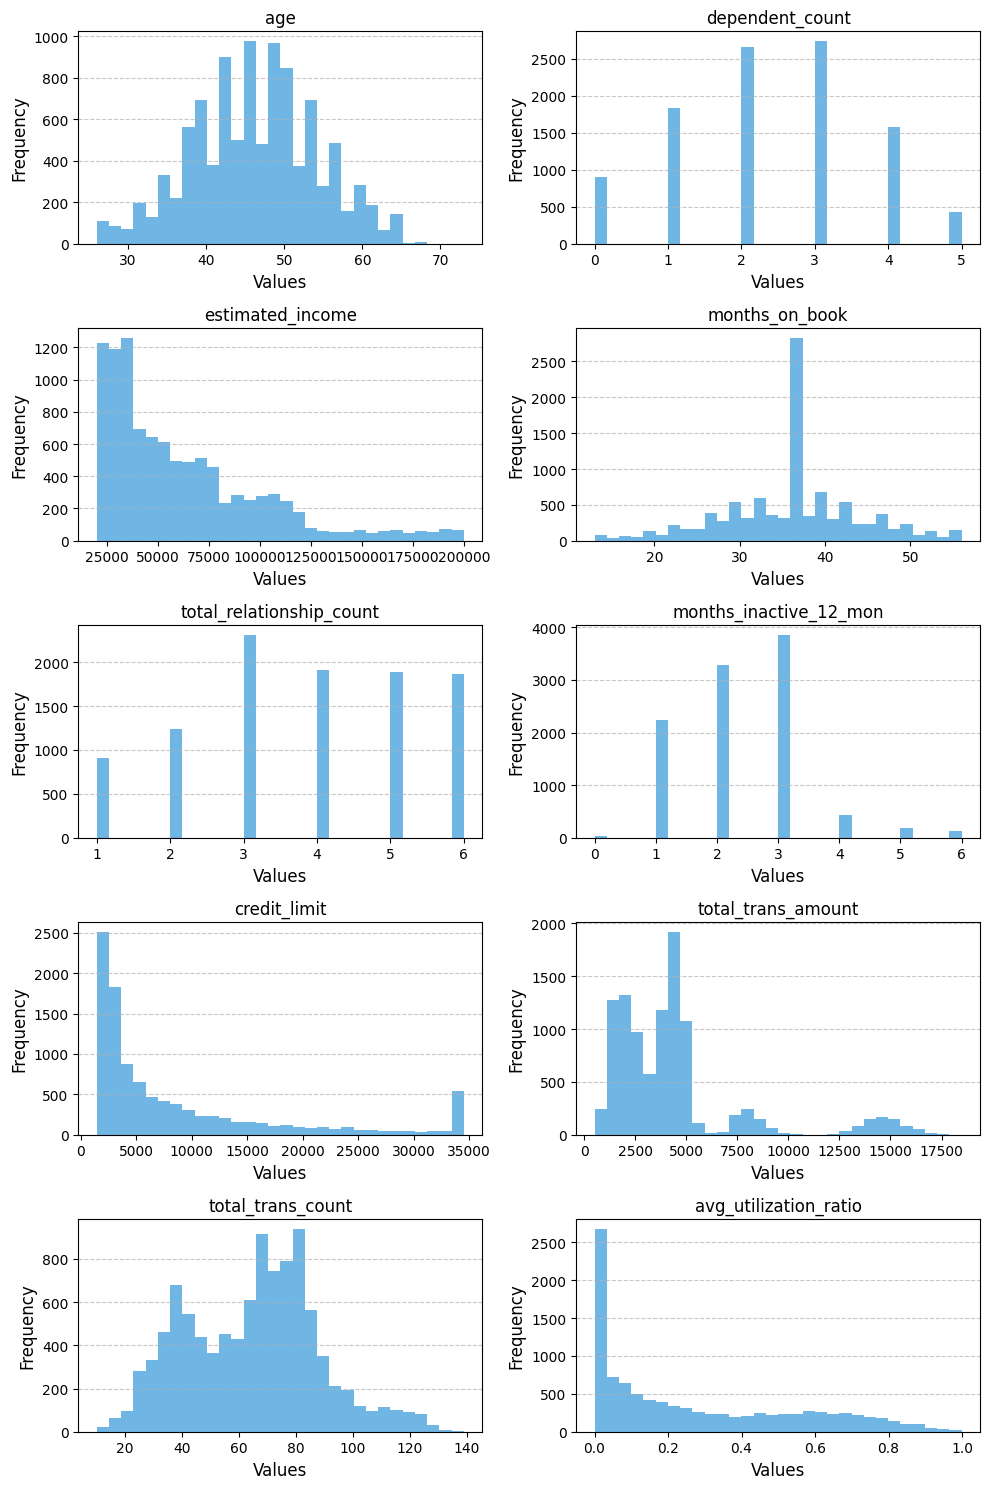

In [4]:
numeric_columns = []

for col in customers.columns:
    if col not in categorical_columns:
        numeric_columns.append(col)

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 15))
axes_flat = axes.flatten()
for i, col in enumerate(numeric_columns):
    axes_flat[i].hist(customers[col], bins=30, color='#3498db', alpha=0.7)
    axes_flat[i].set_title(f'{col}')
    axes_flat[i].grid(axis='y', linestyle='--', alpha=0.7)
    axes_flat[i].set_xlabel('Values', fontsize=12)
    axes_flat[i].set_ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

These observations provide insights into the distribution and frequencies of the values in the numeric columns (now known as __numerical features__) in the dataset.

Most distributions are skewed but there are a few with distributions approaching normal such as total transaction count and age.

Months on book has a large number of customers with 36 months as a customer. This could suggest a marketing campaign that was run or an acquisition of a business.

<Axes: >

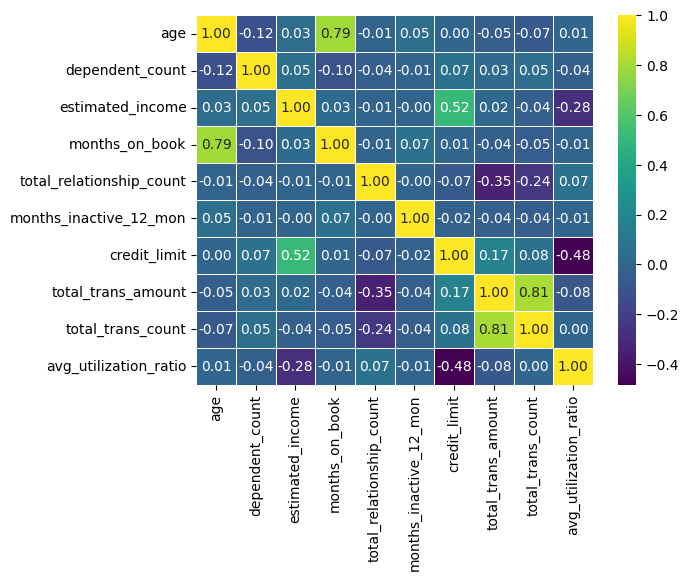

In [5]:
sns.heatmap(customers[numeric_columns].corr(),annot=True, cmap='viridis', fmt='.2f', linewidths=.5)

The numerical features are mostly uncorrelated, with a few exceptions:

- Total transaction amount and total transaction count have a positive correlation.

- Credit limit and estimated income have a positive correlation.

- Age and months on book have a positive correlation.

- Average utilisation ratio (of a customers credit) and credit limit have a negative correlation.

All of the above are expected.

***
### Feature Engineering

The 3 categorical columns need to be coverted into numeric so they can be used in the K-Means model. Approach follows:

<div style="display: flex; justify-content: space-between;">
    <div style="width: 33%; background-color: #FFFFFF; padding: 10px;">
        <p><b>Gender</b><br>
        <i>A simple Lambda will be used</i><br>
<p>F = 0<br>
M = 1<br>
</p>
    </div>
    <div style="width: 33%; background-color: #FFFFFF; padding: 10px;">
        <p><b>Educational Level</b><br>
        <i>Mapping will be used</i><br>
<p>Uneducated = 0<br>
High School = 1<br>
College = 2<br>
Graduate = 3<br>
Post-Graduate = 4<br>
Doctorate = 5<br>
</p>
    </div>
    <div style="width: 33%; background-color: #FFFFFF; padding: 10px;">
        <p><b>Marital Status</b><br>
<p>- As there is no level of magnitude with martial status we cannot say one is higher or better than the others therefore we will use one-hot-encoding to create dummy variables and drop the original variable.</p>
    </div>
    
</div>

In [6]:
customers_modified = customers.copy()

customers_modified['gender'] = customers_modified['gender'].apply(lambda gender: 1 if gender =='M' else 0)

mapping_dict = {'Uneducated':0,
                'High School':1,
                'College':2,
                'Graduate':3,
                'Post-Graduate':4,
                'Doctorate':5
                }

customers_modified['education_level'] = customers_modified['education_level'].map(mapping_dict)

customers_dummies = pd.get_dummies(customers_modified['marital_status'], prefix='marital_status', drop_first=True).astype(int)

customers_modified = pd.concat([customers_modified, customers_dummies], axis=1)

customers_modified.drop(['marital_status'], axis=1, inplace=True)

In [7]:
customers_modified.head(3)

,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,1,0,0
1,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,1,0
2,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,1,0,0


***
### Scaling the Data

As the core of the K-means algorithm is the computation of distances between points, if the variables in the dataset are of incomparable magnitudes (for example kilograms vs. millimeters) this could cause issues. 

K-Means performs better when the variables that are used are scaled. StandardScaler from sklearn is used to do this quickly and easily. It works by calculating the __z-score__ for each entry in a column. The formula for the z-score is as follows:

$$z
=
(
x
−
μ
)/
σ$$

x is the data point, μ is the mean, σ is the standard deviation

In [8]:
scaler = StandardScaler()

scaler.fit(customers_modified)

customers_scaled = scaler.transform(customers_modified)

***
### Determine Clusters

One of the most important metrics for evaluating a K-Means algorithm is __inertia.__ 

$$
n
∑
i
=
1
 
(
x
i
−
c
x
i
)
2
$$

xi is a data point, cxi is the centroid assigned to xi

The inertia reflects how far the points assigned to a cluster are from that cluster's centroid. The inertia heavily influences the decision of how many clusters to use in the K-means analysis. Many clusters means a small inertia and fewer clusters means a bigger inertia. However using many clusters results in high computational effort, overfitting, interpretability (makes it harder to make sense and describe the characteristics of each cluster) and diminishing returns. 

There needs to be a trade-off between inertia & clusters. An elbow graph will be used to determine where this trade-off point is for this study.

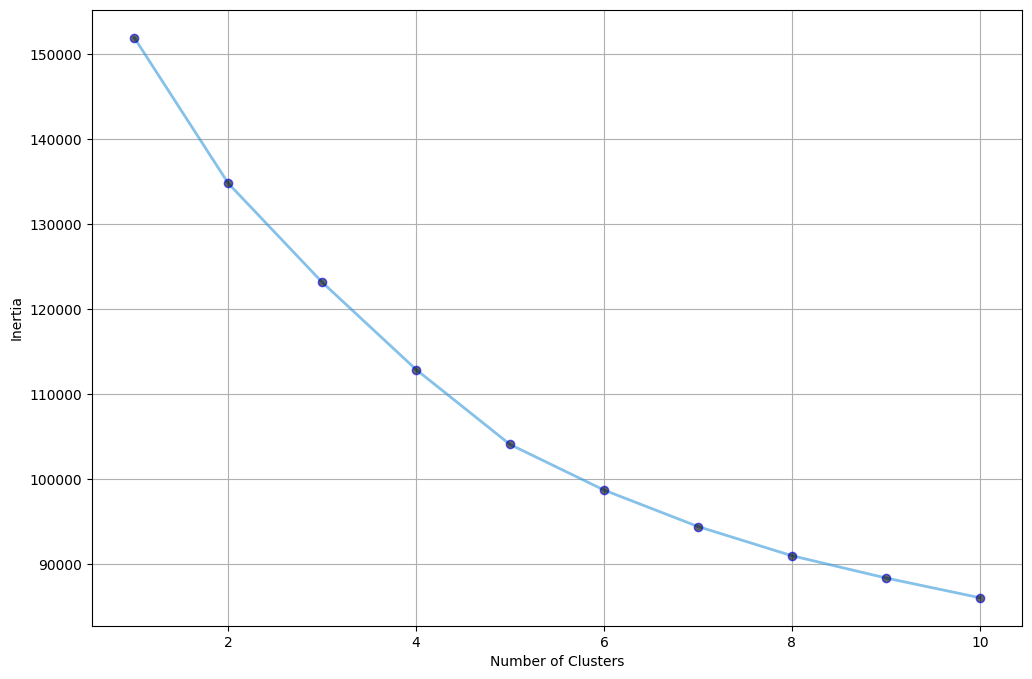

For  1 clusters the model had to iterate  2  times.
For  2 clusters the model had to iterate  14  times.
For  3 clusters the model had to iterate  16  times.
For  4 clusters the model had to iterate  23  times.
For  5 clusters the model had to iterate  35  times.
For  6 clusters the model had to iterate  20  times.
For  7 clusters the model had to iterate  68  times.
For  8 clusters the model had to iterate  30  times.
For  9 clusters the model had to iterate  52  times.
For  10 clusters the model had to iterate  35  times.


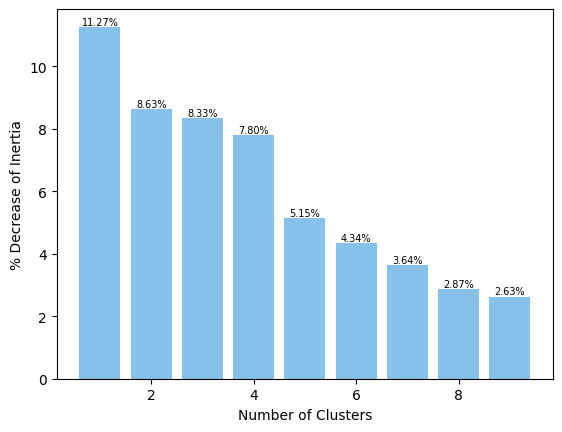

In [9]:
inertias = []
iterations = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, n_init=100)
    kmeans.fit_predict(customers_scaled)
    inertia = kmeans.inertia_
    inertias.append(inertia)
    iteration = kmeans.n_iter_
    iterations.append([i,iteration])
plt.figure(figsize=(12, 8))
plt.plot(range(1,11),inertias,
         color='#3498db', linestyle='-', linewidth=2, marker='o', markersize=6, markerfacecolor='black', markeredgecolor='blue', alpha=0.6)
plt.grid(True)
plt.ylabel("Inertia")
plt.xlabel("Number of Clusters")
plt.show()

for item in iterations:
    print("For ", item[0], "clusters the model had to iterate ", item[1], " times.")

percent_decrease = [((b - a) / a) * -100 for a, b in zip(inertias[:-1], inertias[1:])]

plt.bar(range(1, len(inertias)), percent_decrease, color='#3498db', alpha=0.6)

plt.ylabel("% Decrease of Inertia")
plt.xlabel("Number of Clusters")

for i, value in enumerate(percent_decrease):
    plt.text(i + 1, value, f'{value:.2f}%', ha='center', va='bottom', size=7)

plt.show()

The two graphics show that the rate of inertia decrease begins to slow after the 4th cluster. For the purposes of this analysis, __6 clusters will be chosen.__

***
### Analysing Results


In [10]:
kmeans = KMeans(n_clusters=6, n_init=100)

clusters = kmeans.fit_predict(customers_scaled)

customers['cluster'] = clusters + 1

First, numeric features will be represented:



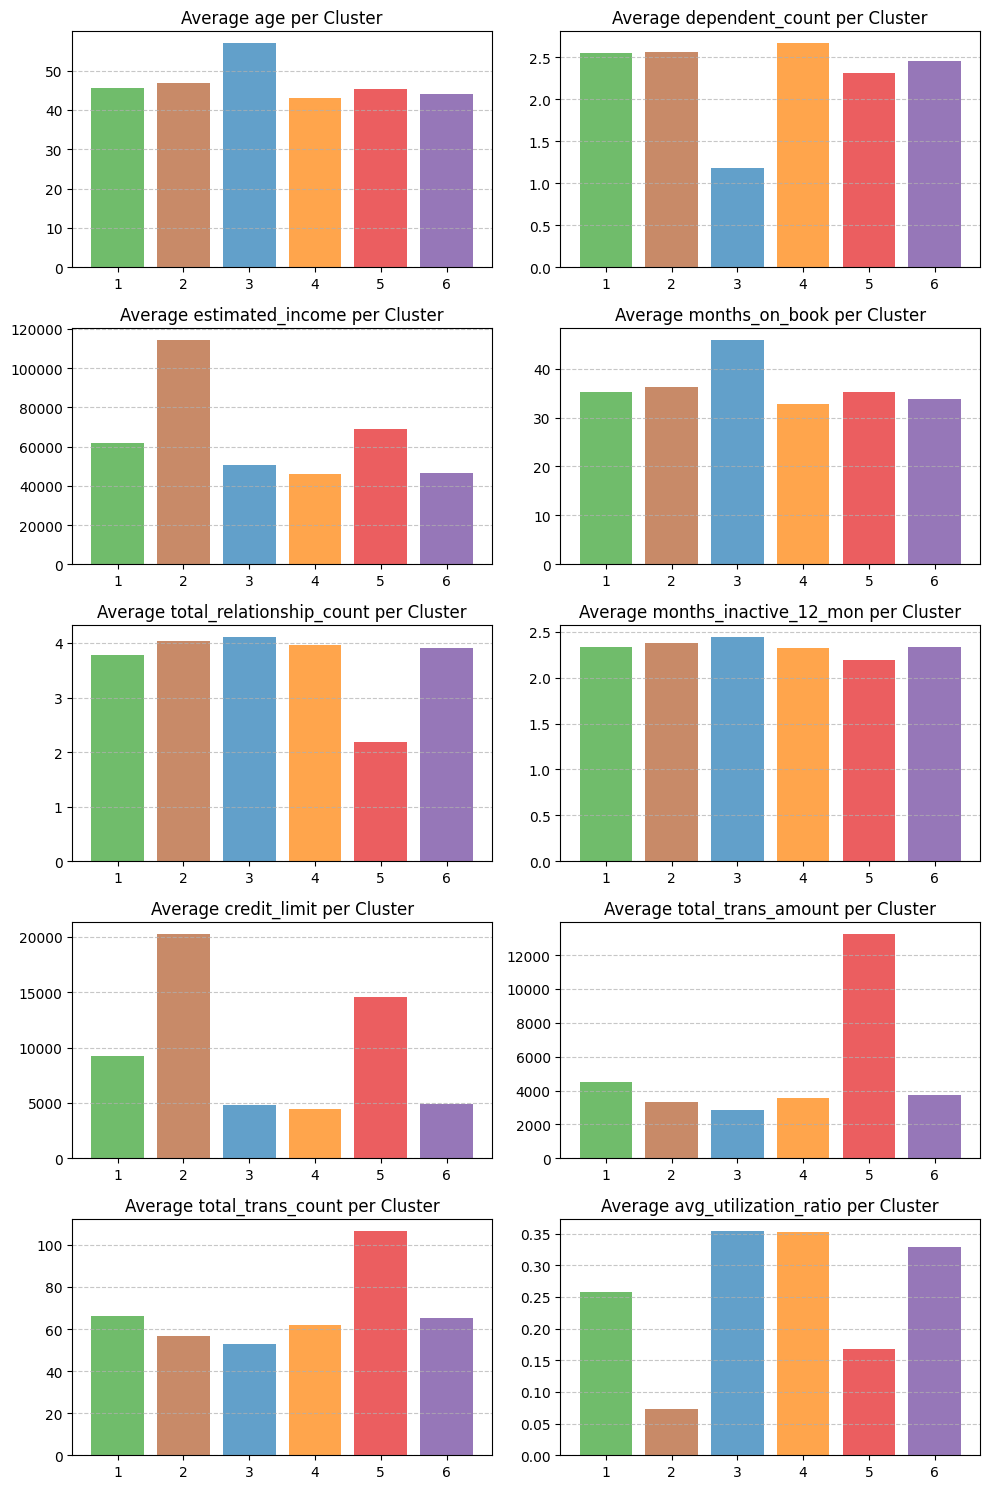

Secondly, the numeric features with a high correlation:



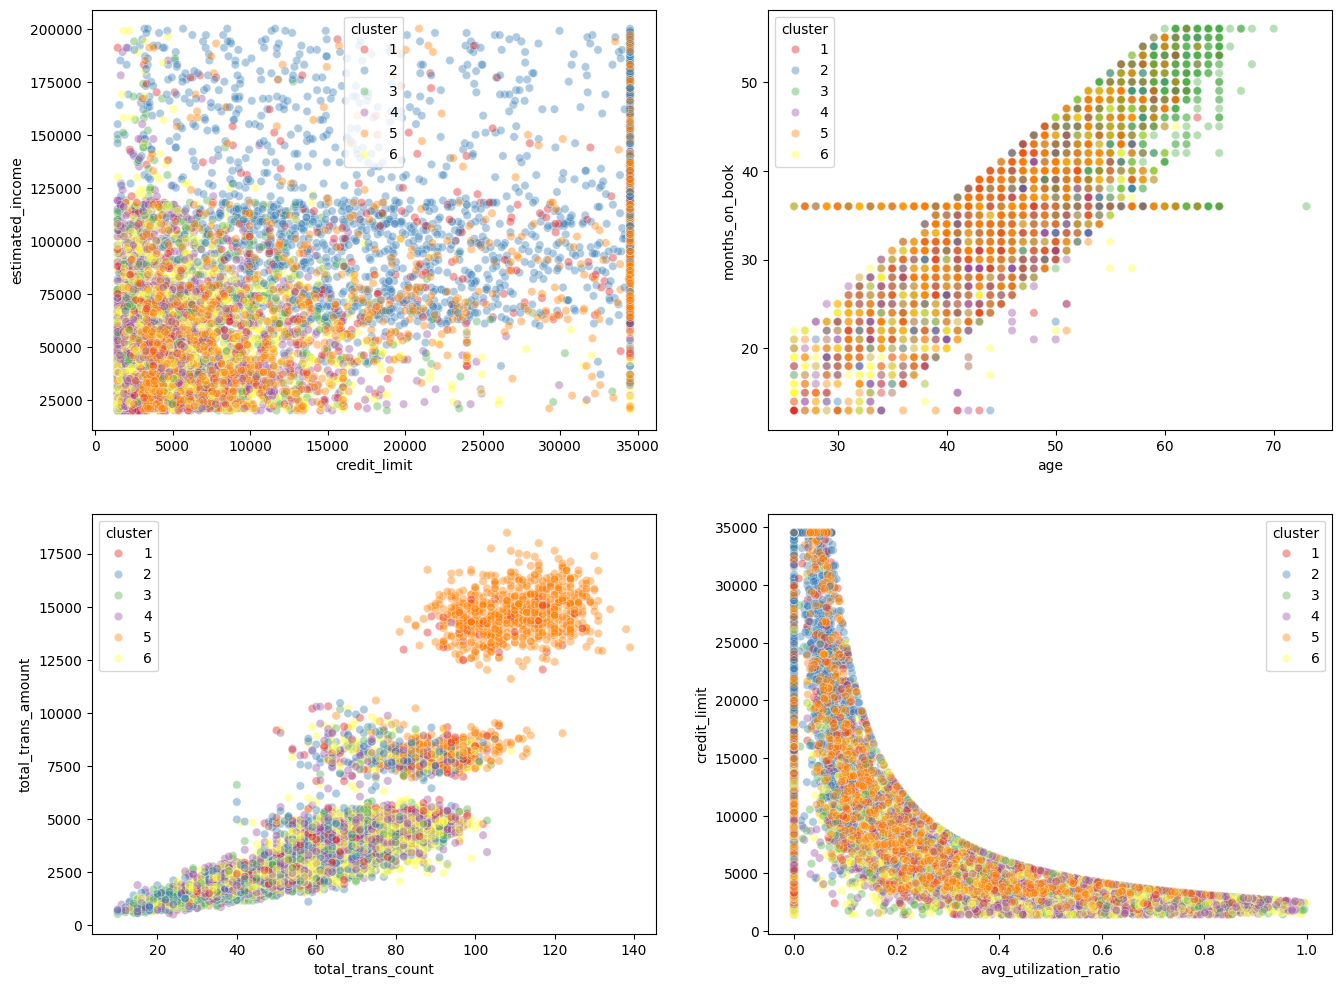

Finally, the categorical features are shown in with a % distribution per cluster:



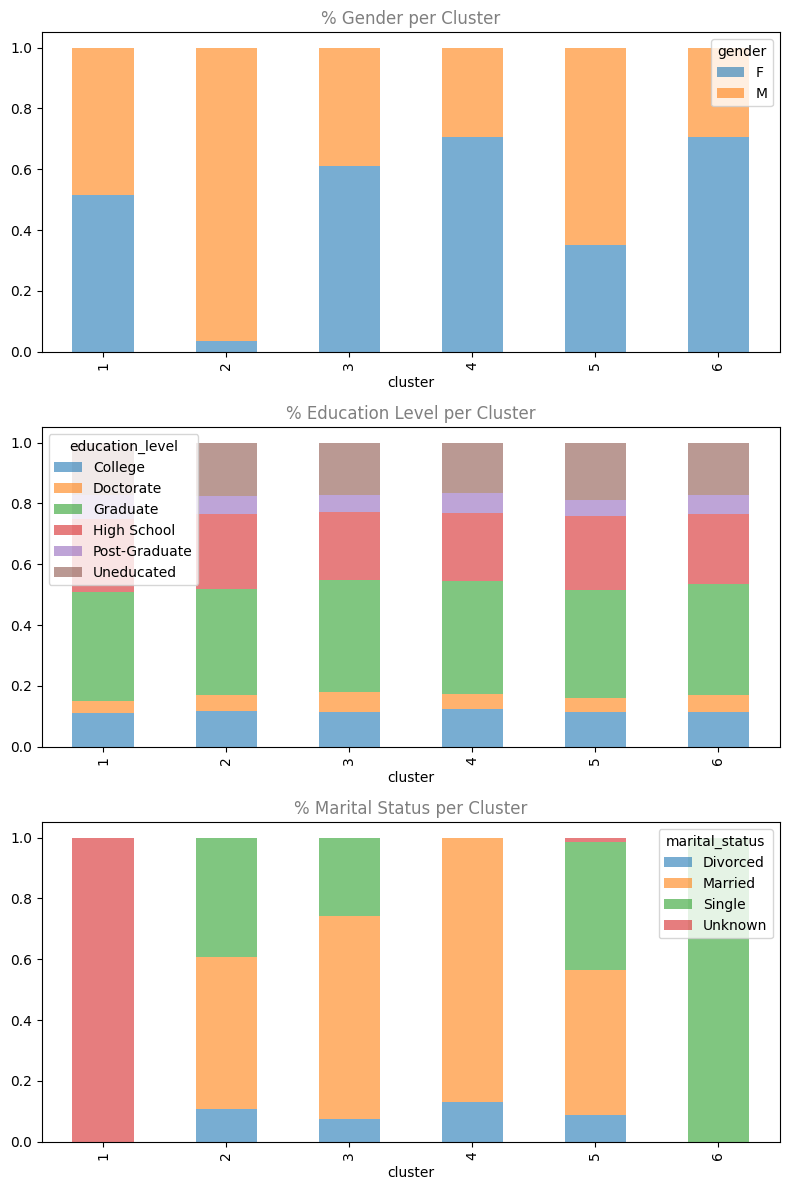

In [11]:
colors_dict = {1: '#1f78b4', 2: '#33a02c', 3: '#e31a1c', 4: '#ff7f00', 5: '#6a3d9a', 6: '#b15928'}
colors = [colors_dict[cluster] for cluster in customers['cluster'].unique()]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 15))
axes_flat = axes.flatten()
for i, col in enumerate(numeric_columns):
    data = customers.groupby('cluster')[col].mean()
    axes_flat[i].bar(data.index, data, alpha=0.7, color=colors)
    axes_flat[i].set_title('Average ' + str(col)+ ' per Cluster')
    axes_flat[i].grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
print("First, numeric features will be represented:\n")
plt.show()

print("Secondly, the numeric features with a high correlation:\n")

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

sns.scatterplot(x='credit_limit', y='estimated_income', hue='cluster', data=customers, palette='Set1', alpha=0.4, ax=axs[0][0])
sns.scatterplot(x='age', y='months_on_book', hue='cluster', data=customers, palette='Set1', alpha=0.4, ax=axs[0][1])
sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='cluster', data=customers, palette='Set1', alpha=0.4, ax=axs[1][0])
sns.scatterplot(x='avg_utilization_ratio', y='credit_limit', hue='cluster', data=customers, palette='Set1', alpha=0.4, ax=axs[1][1])

plt.show()

print("Finally, the categorical features are shown in with a % distribution per cluster:\n")

gender_df = pd.crosstab(
  index=customers['cluster'], columns=customers['gender'],
  values=customers['gender'], aggfunc='size', normalize='index'
)

education_level_df = pd.crosstab(
  index=customers['cluster'], columns=customers['education_level'],
  values=customers['education_level'], aggfunc='size', normalize='index'
)

marital_status_df = pd.crosstab(
  index=customers['cluster'], columns=customers['marital_status'],
  values=customers['marital_status'], aggfunc='size', normalize='index'
)

fig, axes = plt.subplots(3, 1, figsize=(8, 12))

gender_df.plot.bar(stacked=True, ax=axes[0], alpha=0.6)
axes[0].set_title(f'% Gender per Cluster', alpha=0.5)

education_level_df.plot.bar(stacked=True, ax=axes[1], alpha=0.6)
axes[1].set_title(f'% Education Level per Cluster', alpha=0.5)

marital_status_df.plot.bar(stacked=True, ax=axes[2], alpha=0.6)
axes[2].set_title(f'% Marital Status per Cluster', alpha=0.5)

plt.tight_layout()
plt.show()

From the above graphics it was determined that some features have low discriminatory power and are potentially redundant. These features are determined by having a very similar split of means or distribution across each cluster.

These features are __Education Level, Months on the Book, Age, Dependent Count, Relationship and Months Inactive.__ 

Further, transaction count and value are very closely correlated (if one is relatively high so is the other) - also to be removed __Transaction Count.__

The study will be repeated with these features removed.

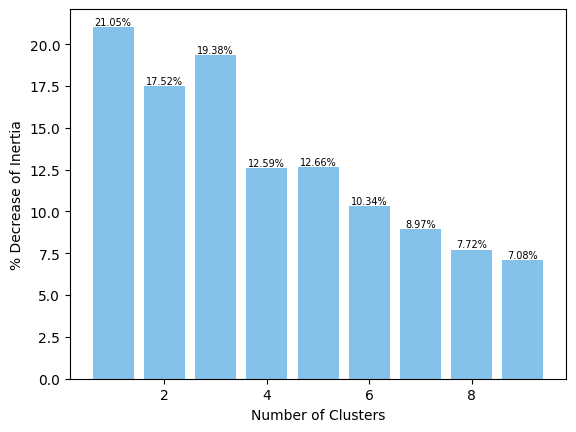

First, numeric features will be represented:



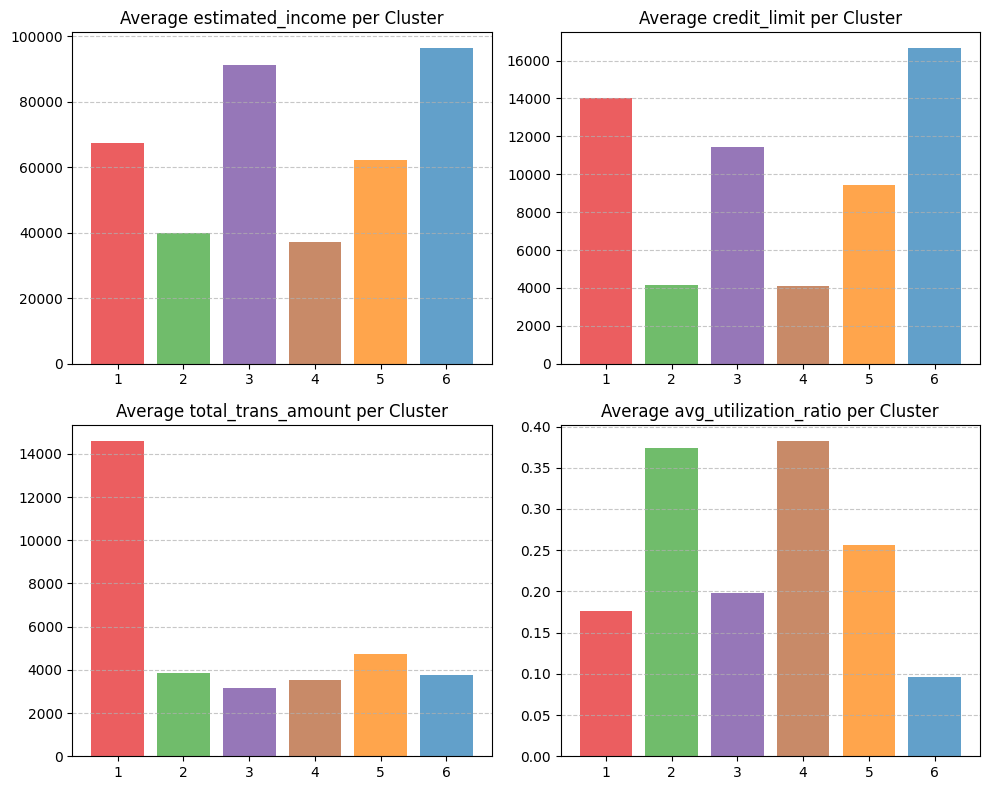

Secondly, the numeric features with a high correlation:



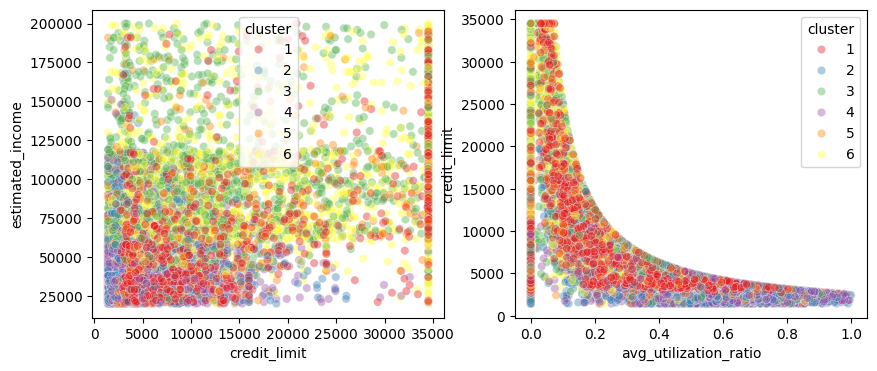

Finally, the categorical features are shown in with a % distribution per cluster:



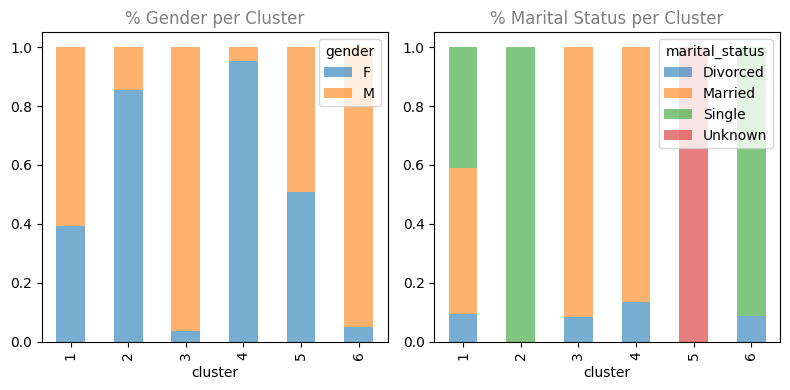

In [45]:
customers = pd.read_csv('data/customer_segmentation.csv')

customers = customers.drop(columns=['customer_id', 'education_level', 'months_inactive_12_mon', 'months_on_book', 'age','dependent_count', 'total_relationship_count','total_trans_count'])

categorical_columns = ['gender','marital_status']

numeric_columns = []

for col in customers.columns:
    if col not in categorical_columns:
        numeric_columns.append(col)

customers_modified = customers.copy()

customers_modified['gender'] = customers_modified['gender'].apply(lambda gender: 1 if gender =='M' else 0)

customers_dummies = pd.get_dummies(customers_modified['marital_status'], prefix='marital_status', drop_first=True).astype(int)

customers_modified = pd.concat([customers_modified, customers_dummies], axis=1)

customers_modified.drop(['marital_status'], axis=1, inplace=True)

scaler = StandardScaler()

scaler.fit(customers_modified)

customers_scaled = scaler.transform(customers_modified)

inertias = []
iterations = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, n_init=100)
    kmeans.fit_predict(customers_scaled)
    inertia = kmeans.inertia_
    inertias.append(inertia)

percent_decrease = [((b - a) / a) * -100 for a, b in zip(inertias[:-1], inertias[1:])]

plt.bar(range(1, len(inertias)), percent_decrease, color='#3498db', alpha=0.6)

plt.ylabel("% Decrease of Inertia")
plt.xlabel("Number of Clusters")

for i, value in enumerate(percent_decrease):
    plt.text(i + 1, value, f'{value:.2f}%', ha='center', va='bottom', size=7)

plt.show()

kmeans = KMeans(n_clusters=6, n_init=100)

clusters = kmeans.fit_predict(customers_scaled)

customers['cluster'] = clusters + 1


colors_dict = {1: '#1f78b4', 2: '#33a02c', 3: '#e31a1c', 4: '#ff7f00', 5: '#6a3d9a', 6: '#b15928'}
colors = [colors_dict[cluster] for cluster in customers['cluster'].unique()]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
axes_flat = axes.flatten()
for i, col in enumerate(numeric_columns):
    data = customers.groupby('cluster')[col].mean()
    axes_flat[i].bar(data.index, data, alpha=0.7, color=colors)
    axes_flat[i].set_title('Average ' + str(col)+ ' per Cluster')
    axes_flat[i].grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
print("First, numeric features will be represented:\n")

plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(x='credit_limit', y='estimated_income', hue='cluster', data=customers, palette='Set1', alpha=0.4, ax=axes[0])
sns.scatterplot(x='avg_utilization_ratio', y='credit_limit', hue='cluster', data=customers, palette='Set1', alpha=0.4, ax=axes[1])
print("Secondly, the numeric features with a high correlation:\n")

plt.show()

print("Finally, the categorical features are shown in with a % distribution per cluster:\n")

gender_df = pd.crosstab(
  index=customers['cluster'], columns=customers['gender'],
  values=customers['gender'], aggfunc='size', normalize='index'
)

marital_status_df = pd.crosstab(
  index=customers['cluster'], columns=customers['marital_status'],
  values=customers['marital_status'], aggfunc='size', normalize='index'
)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

gender_df.plot.bar(stacked=True, ax=axes[0], alpha=0.6)
axes[0].set_title(f'% Gender per Cluster', alpha=0.5)

marital_status_df.plot.bar(stacked=True, ax=axes[1], alpha=0.6)
axes[1].set_title(f'% Marital Status per Cluster', alpha=0.5)

plt.tight_layout()
plt.show()

Using the above features and clusters means there is a much higher discriminatory power, cluster seperation, relevance of the features and interpretability. Also, computational power is reduced when dealing with lower numbers of features.

__The suggestion would be to use these features to split the customers of the credit card company into groups.__

__Cluster 1__ contains slightly more males to females. Higher end of average income, 2nd highest credit limit, highest spenders and have a moderate utilisation of credit limit. They are the loyal and happy big spending customers.
<br>
<u>Business suggestion:</u> Dynamic credit limits depending on the pattern of their spend. Personalised services to enhance loyality such as discounts and premium customer support (which may not be used anyway).
<br>

__Cluster 2__ is made up of ~83% female to male customers who are all single, a below average income, low credit limit but high utilisation of this limit. 
<br>
<u>Business suggestion:</u> recognising the lower income level and single status in this cluster, marketing strategies can focus on offering affordable financial solutions, savings and investment options, and tailored offers to address the specific needs and aspirations of single individuals. These are the high risk but potentially high reward clients and every effort should be made to help however possible.
<br>

__Cluster 3__ contains _almost_ 100 %  male customers who are _almost_ all married with a high estimated income, high credit limit and just below average utilisation of this limit.
<br>
<u>Business suggestion:</u> After ensuring suitability these customers could be suggested higher credit limits. Loyality could be rewarded.
<br>

__Cluster 4__ contains _almost_ 100 %  female customers who are _almost_ all married with a low estimated income, low credit limit and the highest utilisation of this limit over the clusters.
<br>
<u>Business suggestion:</u> A concerted look at their overdraft, debts and offer services that could help. Maybe their spouse has a higher income and further investigation can be done to explore this.
<br>

__Cluster 5__ contains ~50% male and ~50% female customers of unknown marital status, moderate income, moderate credit limit and moderate utilisation of this limit.
<br>
<u>Business suggestion:</u> Since the majority of customers in this cluster have an unknown marital status, it would be beneficial to conduct targeted marketing campaigns to understand their needs and preferences better. Additionally, efforts can be made to collect data on their marital status to further personalise marketing strategies.
<br>

__Cluster 6__ contains _almost_ 100 % male customers who are _almost_ all single or divorced with the highest income, highest credit limit but lowest utilisation of this limit.
<br>
<u>Business suggestion:</u> These customers could benefit from some incentives to entice them to start using their credit card - such as air-miles and reduced interest rates (they probably wouldn't use anyway). Alternative products such as financial planning could be suggested through tailored marketing.
<br>
<br>